# PLOO Water Temperature ADS- 506 Project
## Install and load packages

In [40]:
#install.packages('fpp2')
#install.packages('import')
#install.packages('caret')
#install.packages('readr')
#install.packages('tidyverse')
#install.packages('zoo')
#install.packages('gridExtra')
#install.packages('forecast')

In [41]:
library(caret)
library(forecast)
library(gridExtra)
library(import)
library(readr)
library(fpp2)
library(zoo)
library(tidyverse)

## Load data

In [9]:
# read in data
df <- read_csv('PLOO_water_temperature_2022_datasd.csv', show_col_types = FALSE)
head(df)

project,Deployment#,unixtime_1000_gmt,datetime_pst,depth_m,parameter,units,value,qualifier_flag
<chr>,<dbl>,<dbl>,<dttm>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
PLOO_RTOMS,3,1.641024e+12,2022-01-01,1,Water temperature,degrees Celsius,15.635,1
PLOO_RTOMS,3,1.641024e+12,2022-01-01,9,Water temperature,degrees Celsius,15.644,1
PLOO_RTOMS,3,1.641024e+12,2022-01-01,20,Water temperature,degrees Celsius,15.648,1
PLOO_RTOMS,3,1.641024e+12,2022-01-01,30,Water temperature,degrees Celsius,15.376,1
PLOO_RTOMS,3,1.641024e+12,2022-01-01,45,Water temperature,degrees Celsius,13.385,1
PLOO_RTOMS,3,1.641024e+12,2022-01-01,60,Water temperature,degrees Celsius,12.047,1


# EDA & Pre-processing
## Convert the start date to a POSIXct object

In [10]:
# convert the start date string into a POSIXct object
df$datetime_pst <- as.POSIXct(df$datetime_pst, format='%Y-%m-%d %H:%M:%S')
head(df)

project,Deployment#,unixtime_1000_gmt,datetime_pst,depth_m,parameter,units,value,qualifier_flag
<chr>,<dbl>,<dbl>,<dttm>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
PLOO_RTOMS,3,1.641024e+12,2022-01-01,1,Water temperature,degrees Celsius,15.635,1
PLOO_RTOMS,3,1.641024e+12,2022-01-01,9,Water temperature,degrees Celsius,15.644,1
PLOO_RTOMS,3,1.641024e+12,2022-01-01,20,Water temperature,degrees Celsius,15.648,1
PLOO_RTOMS,3,1.641024e+12,2022-01-01,30,Water temperature,degrees Celsius,15.376,1
PLOO_RTOMS,3,1.641024e+12,2022-01-01,45,Water temperature,degrees Celsius,13.385,1
PLOO_RTOMS,3,1.641024e+12,2022-01-01,60,Water temperature,degrees Celsius,12.047,1


## Create subsets of the df for each depth 

In [11]:
## splice data for each depth ##
df_1m <- subset(df, depth_m==1)
df_9m <- subset(df, depth_m==9)
df_20m <- subset(df, depth_m==20)
df_30m <- subset(df, depth_m==30)
df_45m <- subset(df, depth_m==45)
df_60m <- subset(df, depth_m==60)
df_74m <- subset(df, depth_m==74)
df_87m <- subset(df, depth_m==87)

## Temperature distrobution summaries by depth

In [12]:
#Create empty data frame
output = data.frame()

# add the summary table for each depth to the output df
depths_df <- list(df_1m, df_9m, df_20m, df_30m, df_45m, df_60m, df_74m, df_87m)
for (x in depths_df) {
  sum = summary(x$value)
  output = rbind(output,sum)
}

# name columns
colnames(output) = c("Min.","1st Qu.","Median","Mean","3rd Qu.","Max.", "NA's")

# add a cxolumn to label depth
depths <- list(1, 9, 20, 30, 45, 60, 74, 87)
output$Depth <- depths
output <- output[c("Depth","Min.","1st Qu.","Median","Mean","3rd Qu.","Max.", "NA's")]
output

Depth,Min.,1st Qu.,Median,Mean,3rd Qu.,Max.,NA's
<list>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,12.777,15.6400,17.6805,18.40398,21.119,24.720,9376
9,11.125,15.1830,16.1900,16.62779,18.164,23.646,404
20,10.317,13.1120,14.3320,14.21609,15.160,21.549,512
30,9.906,11.7750,12.8400,12.94635,14.012,19.420,3805
45,9.584,10.9855,11.8040,11.88138,12.641,17.646,479
60,9.476,10.4610,11.2240,11.25414,11.962,15.864,497
74,9.419,10.1850,10.8110,10.83222,11.337,14.632,1010
87,9.409,10.1000,10.6440,10.67014,11.160,14.039,600


## Null values - replace using imputation

In [13]:
for (x in depths_df) {print(sum(is.na(x)))}   

[1] 9376
[1] 404
[1] 512
[1] 3805
[1] 479
[1] 497
[1] 1010
[1] 600


In [14]:
impute_null_with_average <- function(x, y) {
  if (is.na(x)) {
    previous_index <- which(!is.na(y))[1]
    next_index <- which(!is.na(y))[2]
    if (!is.na(previous_index) && !is.na(next_index)) {
      previous_value <- y[previous_index]
      next_value <- y[next_index]
      return((previous_value + next_value) / 2) 
    }
  }
  return(x) 
}

In [15]:
# apply the function to impute null values
df_1m <- df_1m %>% rowwise() %>% mutate(value = impute_null_with_average(value, df_1m$value))
df_9m <- df_9m %>% rowwise() %>% mutate(value = impute_null_with_average(value, df_9m$value))
df_20m <- df_20m %>% rowwise() %>% mutate(value = impute_null_with_average(value, df_20m$value))
df_30m <- df_30m %>% rowwise() %>% mutate(value = impute_null_with_average(value, df_30m$value))
df_45m <- df_45m %>% rowwise() %>% mutate(value = impute_null_with_average(value, df_45m$value))
df_60m <- df_60m %>% rowwise() %>% mutate(value = impute_null_with_average(value, df_60m$value))
df_74m <- df_74m %>% rowwise() %>% mutate(value = impute_null_with_average(value, df_74m$value))
df_87m <- df_87m %>% rowwise() %>% mutate(value = impute_null_with_average(value, df_87m$value))

In [16]:
for (y in depths_df) {print(sum(is.na(df_9m)))}

[1] 0
[1] 0
[1] 0
[1] 0
[1] 0
[1] 0
[1] 0
[1] 0


## Create a timeseries for each depth 

In [17]:
# Create time series object
df_1m_ts <- ts(df_1m$value)
df_9m_ts <- ts(df_9m$value)
df_20m_ts <- ts(df_20m$value)
df_30m_ts <- ts(df_30m$value)
df_45m_ts <- ts(df_45m$value)
df_60m_ts <- ts(df_60m$value)
df_74m_ts <- ts(df_74m$value)
df_87m_ts <- ts(df_87m$value)

## Visualize all time-series together

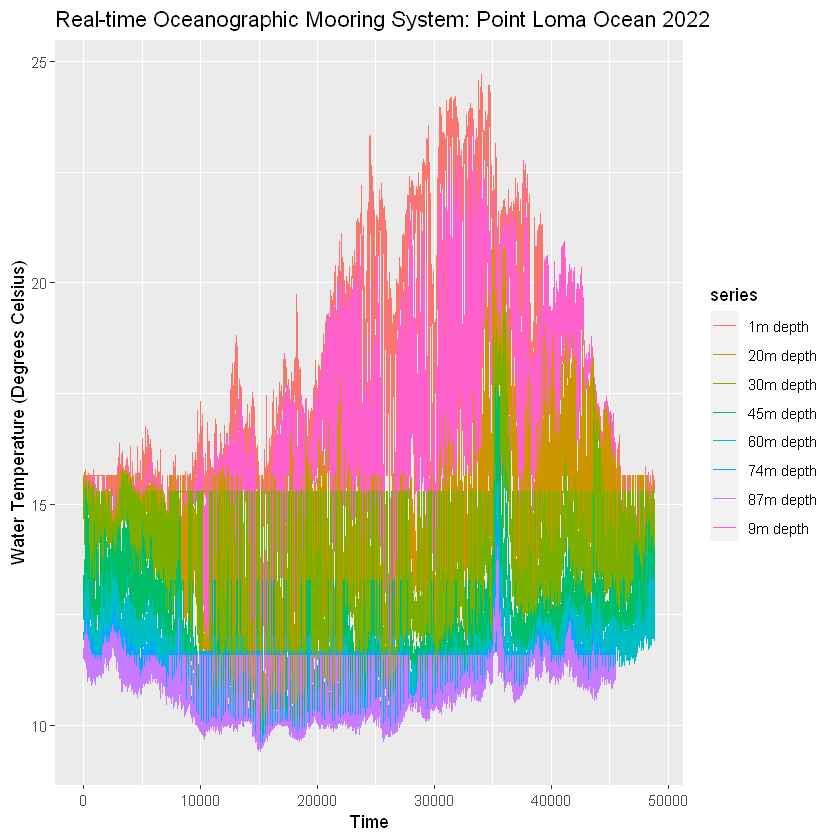

In [18]:
# plot all depths
autoplot(df_1m_ts, main='Real-time Oceanographic Mooring System: Point Loma Ocean 2022', 
    series='1m depth', ylab='Water Temperature (Degrees Celsius)') + 
    autolayer(df_9m_ts, series='9m depth') +
    autolayer(df_20m_ts, series='20m depth') +
    autolayer(df_30m_ts, series='30m depth') +
    autolayer(df_45m_ts, series='45m depth') +
    autolayer(df_60m_ts, series='60m depth') +
    autolayer(df_74m_ts, series='74m depth') +
    autolayer(df_87m_ts, series='87m depth')

## Visualize individual time-series depths

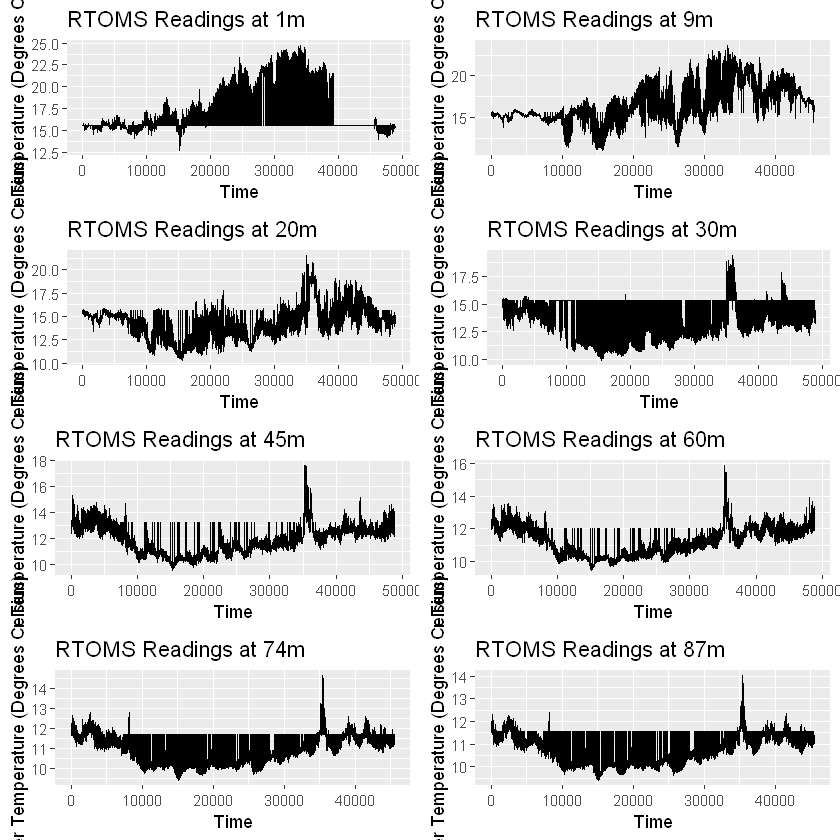

In [19]:
depths_ts <- list(df_1m_ts, df_9m_ts, 
                  df_20m_ts, df_30m_ts, 
                  df_45m_ts, df_60m_ts, 
                  df_74m_ts, df_87m_ts)

n = 1
myplots <- list()
for (x in depths_ts) {
    y <- autoplot(x, main=paste0('RTOMS Readings at ', 
        depths[[n]] ,'m'), ylab='Water Temperature (Degrees Celsius)')
    myplots[[n]] <- y
    n = n +1
}

len <- length(myplots)
nCol <- floor(sqrt(len))
do.call("grid.arrange", c(myplots, ncol=nCol))

## Visualize individual depth histograms

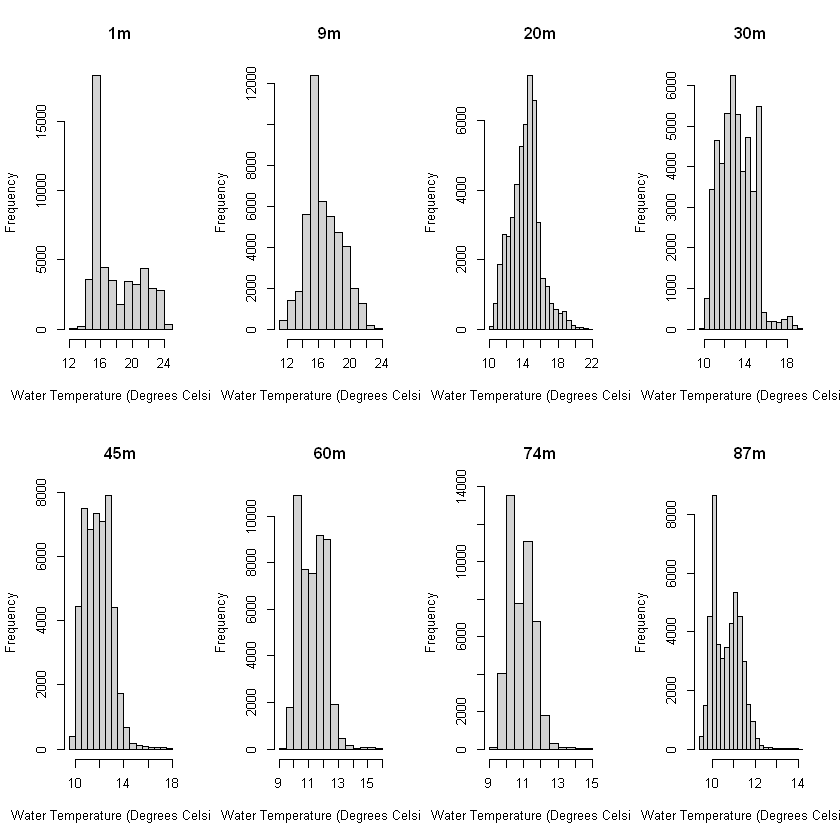

In [20]:
# see distribution of water temperatures
par(mfrow=c(2,4))
hist(df_1m$value, main='1m', xlab= 'Water Temperature (Degrees Celsius)')
hist(df_9m$value, main='9m', xlab= 'Water Temperature (Degrees Celsius)')
hist(df_20m$value, main='20m', xlab= 'Water Temperature (Degrees Celsius)')
hist(df_30m$value, main='30m', xlab= 'Water Temperature (Degrees Celsius)')
hist(df_45m$value, main='45m', xlab= 'Water Temperature (Degrees Celsius)')
hist(df_60m$value, main='60m', xlab= 'Water Temperature (Degrees Celsius)')
hist(df_74m$value, main='74m', xlab= 'Water Temperature (Degrees Celsius)')
hist(df_87m$value, main='87m', xlab= 'Water Temperature (Degrees Celsius)')

## Calculate daily averages then make time series for each depth

In [21]:
## 9m ##
daily_avg_1m <- df_1m %>% group_by(date=as.Date(datetime_pst)) %>% 
    summarize(avg_value = mean(value, na.rm=TRUE))
daily_avg_9m <- df_9m %>% group_by(date=as.Date(datetime_pst)) %>% 
    summarize(avg_value = mean(value, na.rm=TRUE))
daily_avg_20m <- df_20m %>% group_by(date=as.Date(datetime_pst)) %>% 
    summarize(avg_value = mean(value, na.rm=TRUE))
daily_avg_30m <- df_30m %>% group_by(date=as.Date(datetime_pst)) %>% 
    summarize(avg_value = mean(value, na.rm=TRUE))
daily_avg_45m <- df_45m %>% group_by(date=as.Date(datetime_pst)) %>% 
    summarize(avg_value = mean(value, na.rm=TRUE))
daily_avg_60m <- df_60m %>% group_by(date=as.Date(datetime_pst)) %>% 
    summarize(avg_value = mean(value, na.rm=TRUE))
daily_avg_74m <- df_74m %>% group_by(date=as.Date(datetime_pst)) %>% 
    summarize(avg_value = mean(value, na.rm=TRUE))
daily_avg_87m <- df_87m %>% group_by(date=as.Date(datetime_pst)) %>% 
    summarize(avg_value = mean(value, na.rm=TRUE))

In [22]:
daily_avg_1m_ts <- ts(daily_avg_1m$avg_value, frequency=365, start=c(2022,1,1))
daily_avg_9m_ts <- ts(daily_avg_9m$avg_value, frequency=365, start=c(2022,1,1))
daily_avg_20m_ts <- ts(daily_avg_20m$avg_value, frequency=365, start=c(2022,1,1))
daily_avg_30m_ts <- ts(daily_avg_30m$avg_value, frequency=365, start=c(2022,1,1))
daily_avg_45m_ts <- ts(daily_avg_45m$avg_value, frequency=365, start=c(2022,1,1))
daily_avg_60m_ts <- ts(daily_avg_60m$avg_value, frequency=365, start=c(2022,1,1))
daily_avg_74m_ts <- ts(daily_avg_74m$avg_value, frequency=365, start=c(2022,1,1))
daily_avg_87m_ts <- ts(daily_avg_87m$avg_value, frequency=365, start=c(2022,1,1))

## Plot Daily Averages

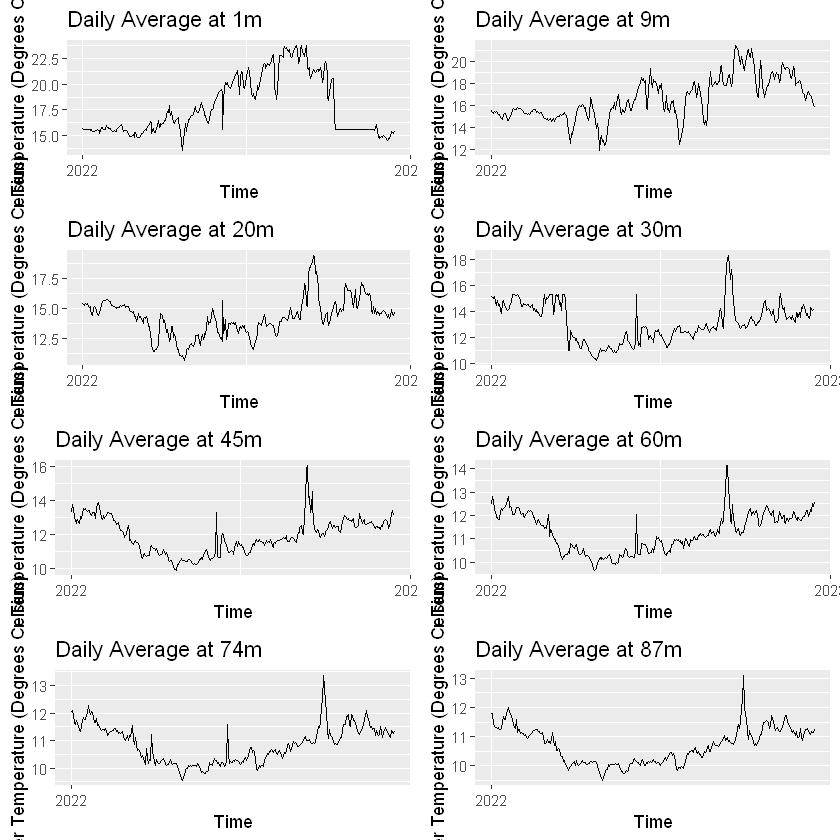

In [23]:
average_ts <- list(daily_avg_1m_ts, daily_avg_9m_ts, 
                   daily_avg_20m_ts, daily_avg_30m_ts, 
                   daily_avg_45m_ts, daily_avg_60m_ts, 
                   daily_avg_74m_ts, daily_avg_87m_ts)

n = 1
myplots_avg <- list()
for (x in average_ts) {
    y <- autoplot(x, main=paste0('Daily Average at ', depths[[n]] ,'m'), 
                  ylab='Water Temperature (Degrees Celsius)')
    myplots_avg[[n]] <- y
    n = n +1
}

len <- length(myplots_avg)
nCol <- floor(sqrt(len))
do.call("grid.arrange", c(myplots_avg, ncol=nCol))

# Differencing
## differenced time-series summmary dataframe

In [26]:
df_1m_diff <- diff(df_1m_ts, frequency=365,start=c(2022,1,1))
df_9m_diff <- diff(df_9m_ts, frequency=365,start=c(2022,1,1))
df_20m_diff <- diff(df_20m_ts, frequency=365,start=c(2022,1,1))
df_30m_diff <- diff(df_30m_ts, frequency=365,start=c(2022,1,1))
df_45m_diff <- diff(df_45m_ts, frequency=365,start=c(2022,1,1))
df_60m_diff <- diff(df_60m_ts, frequency=365,start=c(2022,1,1))
df_74m_diff <- diff(df_74m_ts, frequency=365,start=c(2022,1,1))
df_87m_diff <- diff(df_87m_ts, frequency=365,start=c(2022,1,1))

In [27]:
#Create empty data frame
diff_df = data.frame()

# add the summary table for each depth to the output df
diff_dfs <- list(df_1m_diff, df_9m_diff, df_20m_diff, df_30m_diff, df_45m_diff, df_60m_diff, df_74m_diff, df_87m_diff)
for (x in diff_dfs) {
  sum = summary(x)
  diff_df = rbind(diff_df,sum)
}

# name columns
colnames(diff_df) = c("Min.","1st Qu.","Median","Mean","3rd Qu.","Max.")

# add a cxolumn to label depth
diff_df$Depth <- depths
diff_df <- diff_df[c("Depth","Min.","1st Qu.","Median","Mean","3rd Qu.","Max.")]
diff_df

Depth,Min.,1st Qu.,Median,Mean,3rd Qu.,Max.
<list>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,-8.6905,-0.013,0.000,-7.882721e-06,0.010,8.8285
9,-5.9290,-0.096,-0.001,-8.783487e-08,0.083,6.2430
20,-5.2205,-0.099,0.000,-2.997482e-05,0.092,5.2625
30,-5.1780,-0.074,0.000,-2.868492e-05,0.069,5.1850
45,-4.0375,-0.052,0.000,-3.992547e-06,0.048,4.0695
60,-3.3955,-0.037,-0.001,1.158862e-05,0.034,3.1225
74,-2.4750,-0.019,0.000,-5.270092e-07,0.018,2.5780
87,-2.0260,-0.011,0.001,-4.896794e-06,0.013,2.0840


## ACF plots for the differenced time series at each depth

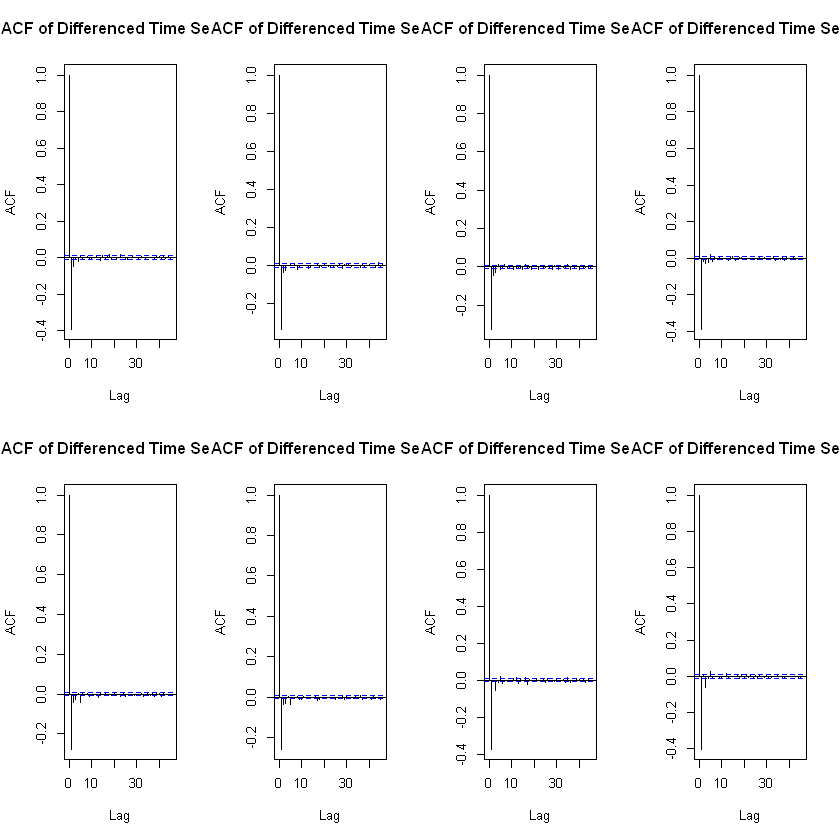

In [32]:
par(mfrow=c(2, 4))
# the other fxn to make a nice grid doesnt work with the acf graphs
for (z in diff_dfs) {
    acf(z, main = "ACF of Differenced Time Series")
}

## PACF plots for the differenced time series at each depth

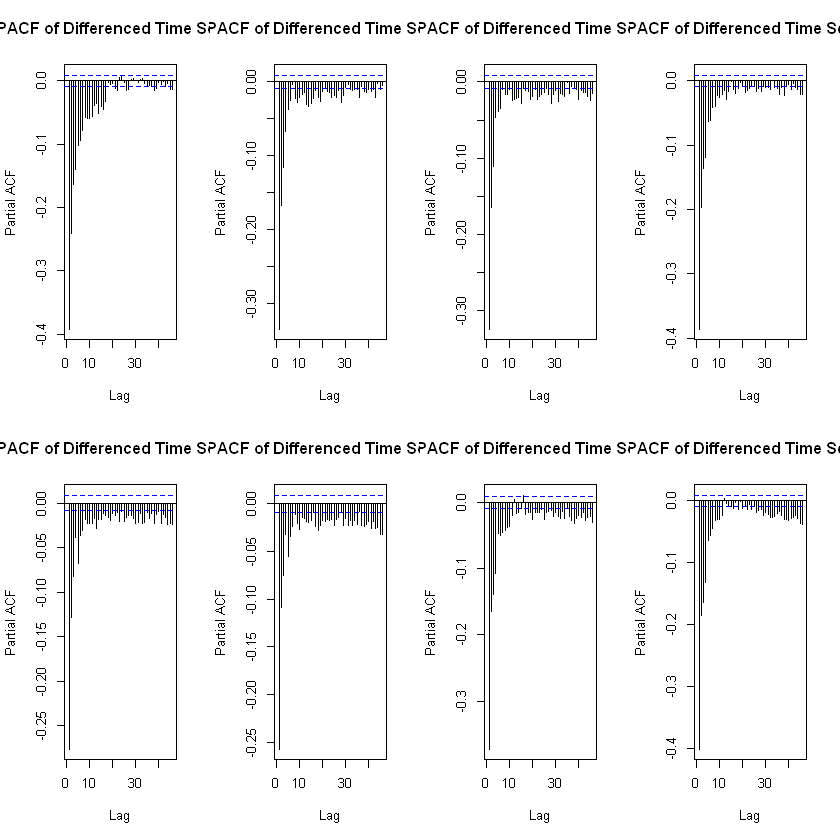

In [34]:
par(mfrow=c(2, 4))
for (z in diff_dfs) {    
    pacf(z, main = "PACF of Differenced Time Series")
}

# Joel Model

## Model 1 - Neural Network (nn_model)
### Neural Networks perform worse when using differencing. Exponential smoothing is prefered. 

### Chosen Time Series - Daily Average Temperatures at 45m Deep

In [76]:
chosen_ts <- daily_avg_45m_ts

### Plot the chosen timeseries

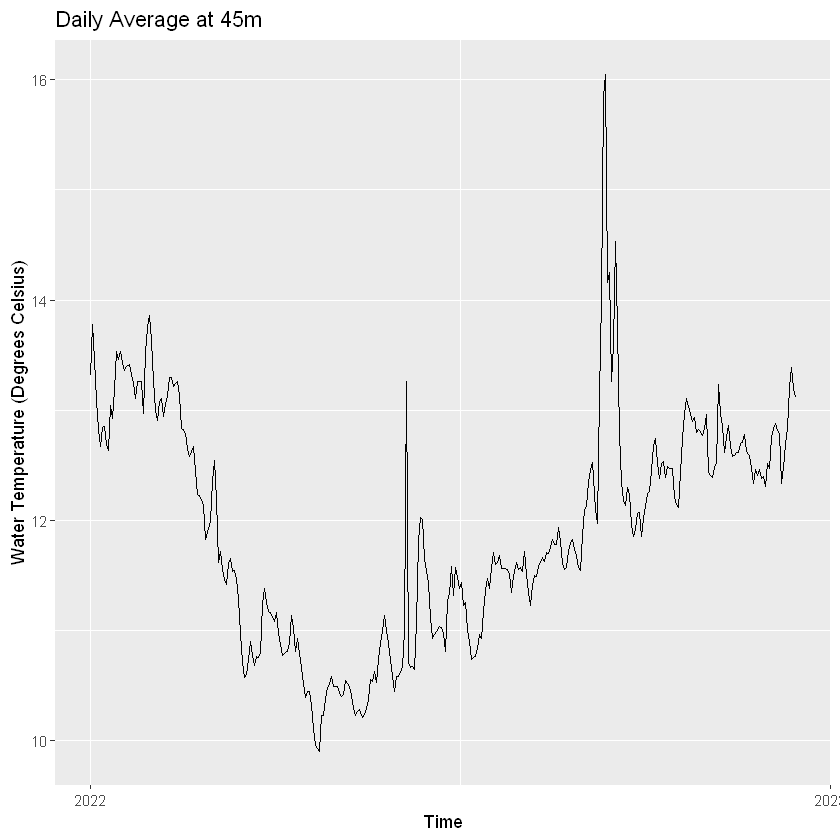

In [77]:
autoplot(chosen_ts, main=paste0('Daily Average at ', 45 ,'m'), ylab='Water Temperature (Degrees Celsius)')

### Partition the TimeSeries

In [80]:
valid <- 7
train <- length(chosen_ts) - valid
train.ts <- window(chosen_ts, end = c(2022, train))
valid.ts <- window(chosen_ts, start = c(2022, train + 1), end = c(2022, train + valid))

In [82]:
length(train.ts)

[1] 342

In [83]:
length(valid.ts)

[1] 7

## Initiate the model
### This series is too short for seasonal lags. Therefore P = 0

In [84]:
set.seed(201)
nn_model <- nnetar(train.ts, repeats = 20, p = 7, P = 0, size = 5)
summary(nn_model)

          Length Class        Mode     
x         342    ts           numeric  
m           1    -none-       numeric  
p           1    -none-       numeric  
P           1    -none-       numeric  
scalex      2    -none-       list     
size        1    -none-       numeric  
subset    342    -none-       numeric  
model      20    nnetarmodels list     
nnetargs    0    -none-       list     
fitted    342    ts           numeric  
residuals 342    ts           numeric  
lags        7    -none-       numeric  
series      1    -none-       character
method      1    -none-       character
call        6    -none-       call     

## the forecasting period should equal the validation period. I used a week. 

In [86]:
nn_model_pred <- forecast(train.ts, h = 7)

In [89]:
accuracy(nn_model_pred, valid.ts)

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,-0.002859152,0.3152058,0.1645771,-0.05330524,1.347615,NaN,-0.01544969,NA
Test set,0.656198973,0.7223894,0.6561990,5.00044667,5.000447,NaN,0.56311162,3.530439


# Jiaqi Modeling

## Model 2 - ARIMA (arima_model)

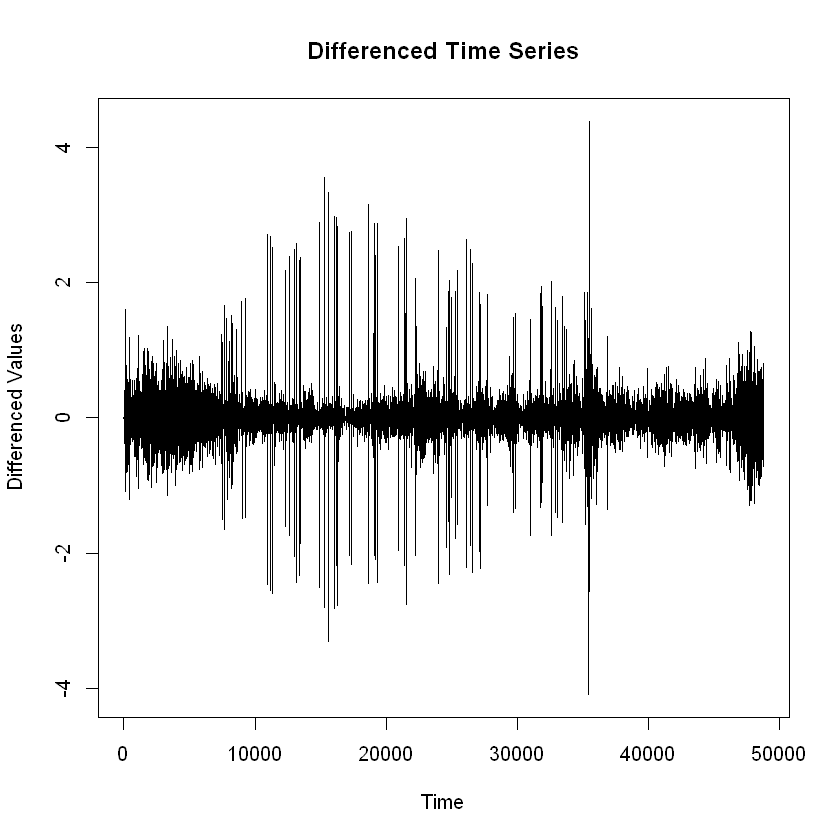

In [58]:
df_45m_diff_model <- Arima(df_45m_ts, order = c(1, 1, 1), seasonal = list(order = c(1, 1, 1)))
arima_model <- residuals(df_45m_diff_model)
plot(arima_model, main = "Differenced Time Series", ylab = "Differenced Values")

In [59]:
summary(arima_model)

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
-4.086788 -0.059352 -0.000561  0.000036  0.057699  4.379539 

## Model 3 - ETS (ets_model)
### fit an ets model

In [90]:
ets_model <- ets(train.ts)
summary(ets_model)

ETS(M,N,N) 

Call:
 ets(y = train.ts) 

  Smoothing parameters:
    alpha = 0.9999 

  Initial states:
    l = 13.3096 

  sigma:  0.0249

     AIC     AICc      BIC 
1164.568 1164.639 1176.072 

Training set error measures:
                       ME      RMSE       MAE         MPE     MAPE MASE
Training set -0.002859152 0.3152058 0.1645771 -0.05330524 1.347615  NaN
                    ACF1
Training set -0.01544969

### Plot predictions

In [91]:
ets_forecast <- forecast(train.ts, h = 7)
accuracy(ets_forecast, valid.ts)

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,-0.002859152,0.3152058,0.1645771,-0.05330524,1.347615,NaN,-0.01544969,NA
Test set,0.656198973,0.7223894,0.6561990,5.00044667,5.000447,NaN,0.56311162,3.530439


In [ ]:
plot(ets_forecast, main = "ETS Model Forecast", ylab = "value", xlab = "time")
# Add the actual time series for comparison
lines(daily_avg_45m_ts, col = "blue", lty = 1)
# Add a legend
legend("topright", legend = c("Actual", "Forecast"), col = c("blue", "red"), lty = 1:1)

## Model 4 - Linear Regression

In [72]:
lin_model <- lm(daily_avg_45m_ts ~ time(daily_avg_45m_ts))
summary(lin_model)


Call:
lm(formula = daily_avg_45m_ts ~ time(daily_avg_45m_ts))

Residuals:
    Min      1Q  Median      3Q     Max 
-1.9107 -0.8529 -0.1468  0.6547  4.0055 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)   
(Intercept)            -1188.3091   401.9265  -2.957  0.00332 **
time(daily_avg_45m_ts)     0.5934     0.1987   2.986  0.00303 **
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.025 on 347 degrees of freedom
Multiple R-squared:  0.02505,	Adjusted R-squared:  0.02224 
F-statistic: 8.917 on 1 and 347 DF,  p-value: 0.003026


In [73]:
predictions <- predict(lin_model)

### Create and plot regression predictions

Don't know how to automatically pick scale for object of type <ts>. Defaulting to continuous.


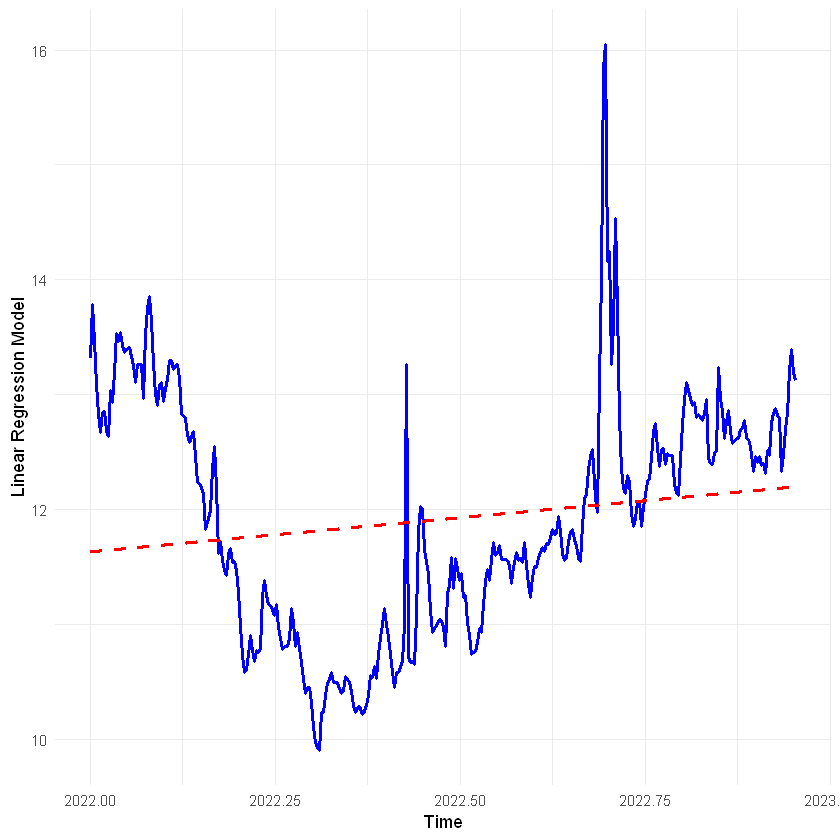

In [74]:
predictions <- predict(lin_model)

# Create a data frame for plotting
plot_data <- data.frame(
  Time = time(daily_avg_45m_ts),
  Actual = as.numeric(daily_avg_45m_ts),
  Predicted = as.numeric(predictions)
)

# Plotting
library(ggplot2)

ggplot(plot_data, aes(x = Time)) +
  geom_line(aes(y = Actual), color = 'blue', size = 1, linetype = 'solid') +
  geom_line(aes(y = Predicted), color = 'red', size = 1, linetype = 'dashed') +
  labs(x = 'Time', y = 'Linear Regression Model') +
  theme_minimal()

# Forcasting for all models
## (e.g., forecast for the next 24 periods)
### List models

In [71]:
list_of_models <- c(nn_model, arima_model, ets_model, lin_model)

ERROR: Error in eval(expr, envir, enclos): object 'lin_model' not found


# Model 1 - Neural Network

## Model 2 - ARIMA

## Model 3 - ETS

# Model 4 - Linear Rgeression